#### Group - Swetha Vijaya Raju, Aniketh Satyanarayana, Sejoon Park, Yong Zhao, Shilpi Kumari

In [127]:
!pip install --upgrade pip
!pip install --upgrade setuptools
!pip install --upgrade "mxnet_cu110<2.0.0"
!pip install autogluon==0.1.0

In [128]:
from autogluon.tabular import TabularPredictor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [129]:
# Read data
df = pd.read_csv('tripadvisor_hotel_reviews.csv', sep=",", header=None, engine='python')  # Finbert data
df.columns = ["Review","Rating"]
print(df.shape)
df.head()

(20492, 2)


,Review,Rating
0,Review,Rating
1,nice hotel expensive parking got good deal sta...,4
2,ok nothing special charge diamond member hilto...,2
3,nice rooms not 4* experience hotel monaco seat...,3
4,"unique, great stay, wonderful time hotel monac...",5


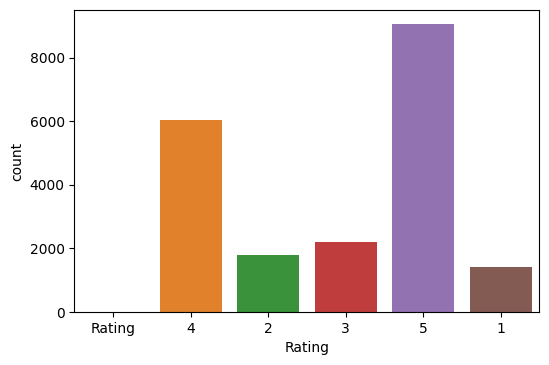

In [130]:
import seaborn as sns
plt.figure(dpi=100)
sns.countplot(x='Rating', data=df)

## Train and Test datasets [1 point]

Create these datasets once and save them for use in answering the 3 questions that follow. 

Use a 80:20 train-test split. 

In [131]:
def train_and_evaluate(df, label='Rating', hyperparameter_tuning=False):
  def print_class_rep(class_rep):
    for rating in ['1', '2', '3','4','5']:
      print("Rating: "+ rating)
      print("Precision: "+ str(class_rep[rating]['precision'])+ ", Recall: "+ str(class_rep[rating]['recall'])+", F1:"+str(class_rep[rating]['f1-score']))

  def evaluate(data, datatype='Train'):
    print("Model Evaluation on "+datatype+" data")
    performance = predictor.evaluate(train_data)
    y_test = data[label]
    data = data.drop(labels=[label],axis=1)
    y_pred = predictor.predict(data)
    y_prob = np.array(predictor.predict_proba(data))
    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    print("Accuracy: "+str(perf['accuracy']))
    print("MCC: "+str(perf['matthews_corrcoef']))
    print("Confusion Matrix: ")
    print(perf['confusion_matrix'])
    print_class_rep(perf['classification_report'])
  
    fpr = {}
    tpr = {}
    thresh ={}
    n_class = 5

    for i in range(5):    
      fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob[:,i], pos_label=str(i+1))
    
    plt.figure(dpi=150)
    plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Rating 1 vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='orange', label='Rating 2 vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='yellow', label='Rating 3 vs Rest')
    plt.plot(fpr[3], tpr[3], linestyle='--',color='pink', label='Rating 4 vs Rest')
    plt.plot(fpr[4], tpr[4], linestyle='--',color='green', label='Rating 5 vs Rest')
    plt.title('Multiclass ROC curve for '+ datatype)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass ROC',dpi=100);
    print('Area under curve (AUC) Rating 1: ', auc(fpr[0],tpr[0]))
    print('Area under curve (AUC) Rating 2: ', auc(fpr[1],tpr[1]))
    print('Area under curve (AUC) Rating 3: ', auc(fpr[2],tpr[2]))
    print('Area under curve (AUC) Rating 4: ', auc(fpr[3],tpr[3]))
    print('Area under curve (AUC) Rating 5: ', auc(fpr[4],tpr[4]))

  train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
  print("Train size =",train_data.shape," | Test size =",test_data.shape)
  if hyperparameter_tuning:
    predictor = TabularPredictor(label=label).fit(train_data=train_data)
  else:
    predictor = TabularPredictor(label=label).fit(train_data=train_data, hyperparameters='multimodal')
  print("Training Complete")
  
  evaluate(train_data, datatype='Train')
  evaluate(test_data, datatype='Test')


## Question 1 [2 points]

1. Using the [Harvard Inquirer Dictionary](http://www.wjh.harvard.edu/~inquirer/inqdict.txt), count the number of positive and negative words in each review. Add two columns to the dataset, one for the count of positive words and the other for the count of negative words. 

2. Show the histogram of these word count columns. 

(You may want to stem the words in the Review column and those in inqdict before you match them and count words. Why?)

In [132]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re

nltk.download('punkt')

def stemText(text_array):
    stemmed_text = []
    for h in text_array:
        if h:
            words = word_tokenize(h)
            h2 = ''
            for w in words:
                h2 = h2 + PorterStemmer().stem(w)
            stemmed_text.append(h2)
    return stemmed_text

def cleanWord(string):
    pattern = re.compile(r'[a-z]+')
    word = string.lower()
    if not word.isalpha():
        word = pattern.findall(word)
    if type(word) == str:
        return word
    if type(word) == list and len(word) != 0:
        return word[0]


def createWordBag(dataset):
  with open('inqdict.txt') as f:
    lines = f.readlines()

  neg_words = list()
  pos_words = list()
  for line in lines[1:]:
      str_array = line.split()
      if "Neg" in str_array:
        word = cleanWord(str_array[0])
        neg_words.append(word)
      elif "Pos" in str_array:
        word = cleanWord(str_array[0])
        pos_words.append(word)
  return set(stemText(pos_words)), set(stemText(neg_words))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [133]:
df['Review_Words'] = df.Review.apply(lambda r : r.split())
df['Stemmed_Review'] = df.Review_Words.apply(lambda r : stemText([cleanWord(word) for word in r]))
df

,Review,Rating,Review_Words,Stemmed_Review
0,Review,Rating,[Review],[review]
1,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expens, park, got, good, deal, s..."
2,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...","[ok, noth, special, charg, diamond, member, hi..."
3,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, 4*, experience, hotel, mona...","[nice, room, not, experi, hotel, monaco, seatt..."
4,"unique, great stay, wonderful time hotel monac...",5,"[unique,, great, stay,, wonderful, time, hotel...","[uniqu, great, stay, wonder, time, hotel, mona..."
...,...,...,...,...
20487,"best kept secret 3rd time staying charm, not 5...",5,"[best, kept, secret, 3rd, time, staying, charm...","[best, kept, secret, rd, time, stay, charm, no..."
20488,great location price view hotel great quick pl...,4,"[great, location, price, view, hotel, great, q...","[great, locat, price, view, hotel, great, quic..."
20489,"ok just looks nice modern outside, desk staff ...",2,"[ok, just, looks, nice, modern, outside,, desk...","[ok, just, look, nice, modern, outsid, desk, s..."
20490,hotel theft ruined vacation hotel opened sept ...,1,"[hotel, theft, ruined, vacation, hotel, opened...","[hotel, theft, ruin, vacat, hotel, open, sept,..."


In [134]:
pos_words, neg_words = createWordBag('inqdict.txt')

In [135]:
df["Pos_Count"] = df.Stemmed_Review.apply(lambda r: len([word for word in r if word in pos_words]))
df["Neg_Count"] = df.Stemmed_Review.apply(lambda r: len([word for word in r if word in neg_words]))
df

,Review,Rating,Review_Words,Stemmed_Review,Pos_Count,Neg_Count
0,Review,Rating,[Review],[review],0,0
1,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expens, park, got, good, deal, s...",21,5
2,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...","[ok, noth, special, charg, diamond, member, hi...",41,20
3,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, 4*, experience, hotel, mona...","[nice, room, not, experi, hotel, monaco, seatt...",34,14
4,"unique, great stay, wonderful time hotel monac...",5,"[unique,, great, stay,, wonderful, time, hotel...","[uniqu, great, stay, wonder, time, hotel, mona...",23,5
...,...,...,...,...,...,...
20487,"best kept secret 3rd time staying charm, not 5...",5,"[best, kept, secret, 3rd, time, staying, charm...","[best, kept, secret, rd, time, stay, charm, no...",17,15
20488,great location price view hotel great quick pl...,4,"[great, location, price, view, hotel, great, q...","[great, locat, price, view, hotel, great, quic...",8,1
20489,"ok just looks nice modern outside, desk staff ...",2,"[ok, just, looks, nice, modern, outside,, desk...","[ok, just, look, nice, modern, outsid, desk, s...",10,8
20490,hotel theft ruined vacation hotel opened sept ...,1,"[hotel, theft, ruined, vacation, hotel, opened...","[hotel, theft, ruin, vacat, hotel, open, sept,...",130,114


Text(0, 0.5, 'Reviews')

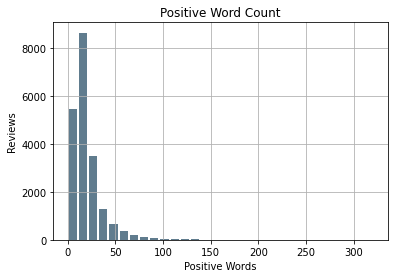

In [136]:
df["Pos_Count"].plot.hist(grid=True, bins=30, rwidth=0.8,
                   color='#607c8e')
plt.title("Positive Word Count")
plt.xlabel('Positive Words')
plt.ylabel('Reviews')
#plt.yscale('log')


Text(0, 0.5, 'Reviews')

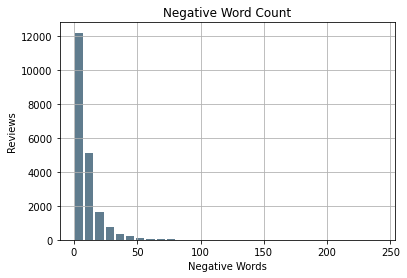

In [137]:
df["Neg_Count"].plot.hist(grid=True, bins=30, rwidth=0.8,
                   color='#607c8e')
plt.title("Negative Word Count")
plt.xlabel('Negative Words')
plt.ylabel('Reviews')
#plt.yscale('log')

In [138]:
df["Total_Tokens"] = df["Stemmed_Review"].apply(lambda r : len(r))

In [139]:
df["Pos_Count_Normalized"] = df["Pos_Count"] / df["Total_Tokens"]
df["Neg_Count_Normalized"] = df["Neg_Count"] / df["Total_Tokens"]
df

,Review,Rating,Review_Words,Stemmed_Review,Pos_Count,Neg_Count,Total_Tokens,Pos_Count_Normalized,Neg_Count_Normalized
0,Review,Rating,[Review],[review],0,0,1,0.000000,0.000000
1,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expens, park, got, good, deal, s...",21,5,86,0.244186,0.058140
2,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...","[ok, noth, special, charg, diamond, member, hi...",41,20,243,0.168724,0.082305
3,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, 4*, experience, hotel, mona...","[nice, room, not, experi, hotel, monaco, seatt...",34,14,208,0.163462,0.067308
4,"unique, great stay, wonderful time hotel monac...",5,"[unique,, great, stay,, wonderful, time, hotel...","[uniqu, great, stay, wonder, time, hotel, mona...",23,5,88,0.261364,0.056818
...,...,...,...,...,...,...,...,...,...
20487,"best kept secret 3rd time staying charm, not 5...",5,"[best, kept, secret, 3rd, time, staying, charm...","[best, kept, secret, rd, time, stay, charm, no...",17,15,108,0.157407,0.138889
20488,great location price view hotel great quick pl...,4,"[great, location, price, view, hotel, great, q...","[great, locat, price, view, hotel, great, quic...",8,1,39,0.205128,0.025641
20489,"ok just looks nice modern outside, desk staff ...",2,"[ok, just, looks, nice, modern, outside,, desk...","[ok, just, look, nice, modern, outsid, desk, s...",10,8,63,0.158730,0.126984
20490,hotel theft ruined vacation hotel opened sept ...,1,"[hotel, theft, ruined, vacation, hotel, opened...","[hotel, theft, ruin, vacat, hotel, open, sept,...",130,114,766,0.169713,0.148825


In [140]:
from sklearn.preprocessing import StandardScaler
col_names = ['Pos_Count_Normalized','Neg_Count_Normalized']
features = df[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = (['Scaled_Num_of_pos_words','Scaled_Num_of_neg_words']))
scaled_features

,Scaled_Num_of_pos_words,Scaled_Num_of_neg_words
0,-3.082013,-2.102187
1,0.407133,-0.801573
2,-0.671131,-0.260988
3,-0.746330,-0.596476
4,0.652581,-0.831132
...,...,...
20487,-0.832837,1.004836
20488,-0.150960,-1.528583
20489,-0.813936,0.738520
20490,-0.657007,1.227114


In [141]:
df2 = pd.merge(df,scaled_features,left_index= True, right_index=True)
df2

,Review,Rating,Review_Words,Stemmed_Review,Pos_Count,Neg_Count,Total_Tokens,Pos_Count_Normalized,Neg_Count_Normalized,Scaled_Num_of_pos_words,Scaled_Num_of_neg_words
0,Review,Rating,[Review],[review],0,0,1,0.000000,0.000000,-3.082013,-2.102187
1,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expens, park, got, good, deal, s...",21,5,86,0.244186,0.058140,0.407133,-0.801573
2,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...","[ok, noth, special, charg, diamond, member, hi...",41,20,243,0.168724,0.082305,-0.671131,-0.260988
3,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, 4*, experience, hotel, mona...","[nice, room, not, experi, hotel, monaco, seatt...",34,14,208,0.163462,0.067308,-0.746330,-0.596476
4,"unique, great stay, wonderful time hotel monac...",5,"[unique,, great, stay,, wonderful, time, hotel...","[uniqu, great, stay, wonder, time, hotel, mona...",23,5,88,0.261364,0.056818,0.652581,-0.831132
...,...,...,...,...,...,...,...,...,...,...,...
20487,"best kept secret 3rd time staying charm, not 5...",5,"[best, kept, secret, 3rd, time, staying, charm...","[best, kept, secret, rd, time, stay, charm, no...",17,15,108,0.157407,0.138889,-0.832837,1.004836
20488,great location price view hotel great quick pl...,4,"[great, location, price, view, hotel, great, q...","[great, locat, price, view, hotel, great, quic...",8,1,39,0.205128,0.025641,-0.150960,-1.528583
20489,"ok just looks nice modern outside, desk staff ...",2,"[ok, just, looks, nice, modern, outside,, desk...","[ok, just, look, nice, modern, outsid, desk, s...",10,8,63,0.158730,0.126984,-0.813936,0.738520
20490,hotel theft ruined vacation hotel opened sept ...,1,"[hotel, theft, ruined, vacation, hotel, opened...","[hotel, theft, ruin, vacat, hotel, open, sept,...",130,114,766,0.169713,0.148825,-0.657007,1.227114


In [142]:
df2 = df2.drop(0)

In [143]:
df2

,Review,Rating,Review_Words,Stemmed_Review,Pos_Count,Neg_Count,Total_Tokens,Pos_Count_Normalized,Neg_Count_Normalized,Scaled_Num_of_pos_words,Scaled_Num_of_neg_words
1,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expens, park, got, good, deal, s...",21,5,86,0.244186,0.058140,0.407133,-0.801573
2,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...","[ok, noth, special, charg, diamond, member, hi...",41,20,243,0.168724,0.082305,-0.671131,-0.260988
3,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, 4*, experience, hotel, mona...","[nice, room, not, experi, hotel, monaco, seatt...",34,14,208,0.163462,0.067308,-0.746330,-0.596476
4,"unique, great stay, wonderful time hotel monac...",5,"[unique,, great, stay,, wonderful, time, hotel...","[uniqu, great, stay, wonder, time, hotel, mona...",23,5,88,0.261364,0.056818,0.652581,-0.831132
5,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay,, went, seahawk, gam...","[great, stay, great, stay, went, seahawk, game...",36,21,189,0.190476,0.111111,-0.360321,0.383431
...,...,...,...,...,...,...,...,...,...,...,...
20487,"best kept secret 3rd time staying charm, not 5...",5,"[best, kept, secret, 3rd, time, staying, charm...","[best, kept, secret, rd, time, stay, charm, no...",17,15,108,0.157407,0.138889,-0.832837,1.004836
20488,great location price view hotel great quick pl...,4,"[great, location, price, view, hotel, great, q...","[great, locat, price, view, hotel, great, quic...",8,1,39,0.205128,0.025641,-0.150960,-1.528583
20489,"ok just looks nice modern outside, desk staff ...",2,"[ok, just, looks, nice, modern, outside,, desk...","[ok, just, look, nice, modern, outsid, desk, s...",10,8,63,0.158730,0.126984,-0.813936,0.738520
20490,hotel theft ruined vacation hotel opened sept ...,1,"[hotel, theft, ruined, vacation, hotel, opened...","[hotel, theft, ruin, vacat, hotel, open, sept,...",130,114,766,0.169713,0.148825,-0.657007,1.227114


## Question 2 [2 points]

1. Fit a multi-category machine learning model to the data using only the two new columns you created as features and the Rating column as the label. 

2. Report the confusion matrix, accuracy, precision, recall, f1 score, Matthews correlation coefficient, ROC curve, and the AUC. Report these values on the train and test datasets. 

(Think about how you would like to manage the two features. Do you want to express them as a percentage of total words in the review? Do you want to normalize the columns by scaling?)

In [144]:
df_with_counts = df2.loc[ : ,('Pos_Count', 'Neg_Count', 'Rating')]
df_with_counts

,Pos_Count,Neg_Count,Rating
1,21,5,4
2,41,20,2
3,34,14,3
4,23,5,5
5,36,21,5
...,...,...,...
20487,17,15,5
20488,8,1,4
20489,10,8,2
20490,130,114,1


In [145]:
df_with_scaled_counts = df2.loc[ : ,('Scaled_Num_of_pos_words', 'Scaled_Num_of_neg_words', 'Rating')]
df_with_scaled_counts

,Scaled_Num_of_pos_words,Scaled_Num_of_neg_words,Rating
1,0.407133,-0.801573,4
2,-0.671131,-0.260988,2
3,-0.746330,-0.596476,3
4,0.652581,-0.831132,5
5,-0.360321,0.383431,5
...,...,...,...
20487,-0.832837,1.004836,5
20488,-0.150960,-1.528583,4
20489,-0.813936,0.738520,2
20490,-0.657007,1.227114,1


No path specified. Models will be saved in: "AutogluonModels/ag-20220509_050438/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220509_050438/"
AutoGluon Version:  0.1.0
Train Data Rows:    16392
Train Data Columns: 2
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	5 unique label values:  ['5', '4', '3', '2', '1']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 5
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9977.17 MB
	Train Data (Original)  Memory Usage: 0.26 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.

Train size = (16392, 3)  | Test size = (4099, 3)


	0.4695	 = Validation accuracy score
	31.05s	 = Training runtime
	0.42s	 = Validation runtime
Fitting model: LightGBM ...
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	0.4811	 = Validation accuracy score
	2.06s	 = Training runtime
	0.03s	 = Validation runtime
Fitting model: LightGBMXT ...
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	0.4707	 = Validation accuracy score
	3.51s	 = Training runtime
	0.16

Training Complete
Model Evaluation on Train data
Predictive performance on given data: accuracy = 0.5035993167398731
Accuracy: 0.5035993167398731
MCC: 0.22906595179315178
Confusion Matrix: 
     1    2   3    4     5
1  450  168   1  215   295
2  219  331   6  349   555
3  103  142  33  407  1067
4   79  171   4  942  3591
5   88  120   8  549  6499
Rating: 1
Precision: 0.4792332268370607, Recall: 0.3985828166519043, F1:0.43520309477756286
Rating: 2
Precision: 0.3551502145922747, Recall: 0.2267123287671233, F1:0.27675585284280935
Rating: 3
Precision: 0.6346153846153846, Recall: 0.018835616438356163, F1:0.036585365853658534
Rating: 4
Precision: 0.3826157595450853, Recall: 0.19678295383329852, F1:0.25989791695406267
Rating: 5
Precision: 0.5412675939035563, Recall: 0.8946861233480177, F1:0.6744849774272222
Area under curve (AUC) Rating 1:  0.883902537423702
Area under curve (AUC) Rating 2:  0.8047180322484762
Area under curve (AUC) Rating 3:  0.6971805056516207
Area under curve (AUC) Rati

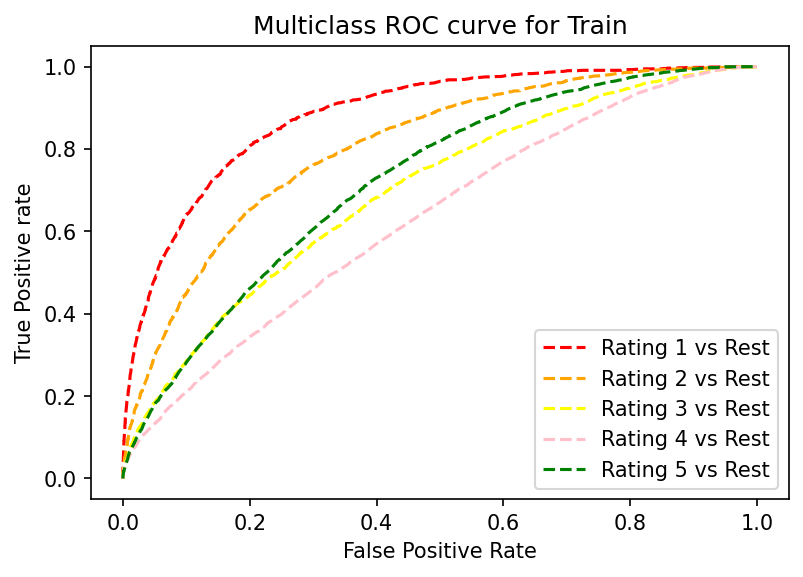

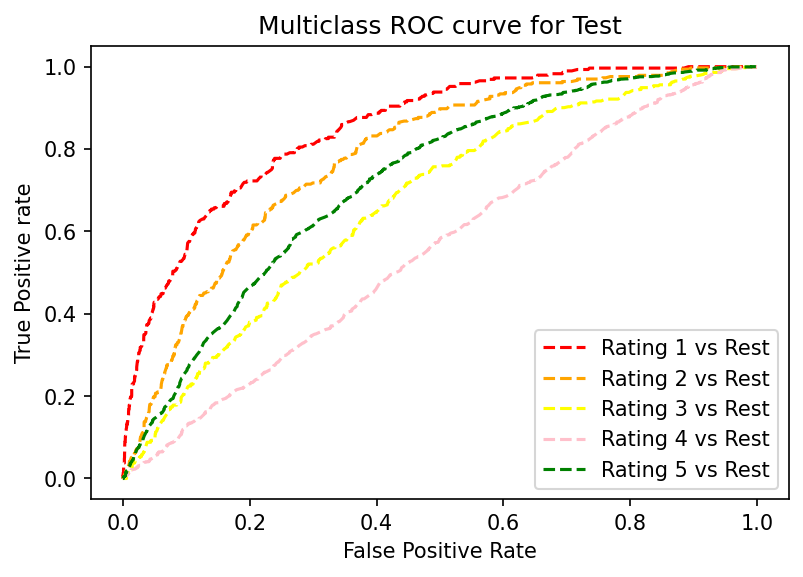

In [146]:
train_and_evaluate(df_with_counts)

No path specified. Models will be saved in: "AutogluonModels/ag-20220509_050601/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220509_050601/"
AutoGluon Version:  0.1.0
Train Data Rows:    16392
Train Data Columns: 2
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	5 unique label values:  ['5', '4', '3', '2', '1']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 5
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10008.5 MB
	Train Data (Original)  Memory Usage: 0.26 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.

Train size = (16392, 3)  | Test size = (4099, 3)


		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 2 | ['Scaled_Num_of_pos_words', 'Scaled_Num_of_neg_words']
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 2 | ['Scaled_Num_of_pos_words', 'Scaled_Num_of_neg_words']
	0.1s = Fit runtime
	2 features in original data used to generate 2 features in processed data.
	Train Data (Processed) Memory Usage: 0.26 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.27s ...
AutoGluon will gauge predictive performance using evaluation metric: 'accuracy'
	To change this, specify the eval_metric argument of fit()
Automatically generating train/validation split with holdout_frac=0.1, Train Rows: 14752, Val Rows: 1640
Fitting model: NeuralNetMXNet ...
	0.4768	 = Validation accuracy score
	66.92s	 = T

Training Complete
Model Evaluation on Train data
Predictive performance on given data: accuracy = 0.4933504148365056
Accuracy: 0.4933504148365056
MCC: 0.212974142653229
Confusion Matrix: 
     1    2   3    4     5
1  430  212   2  212   273
2  222  353   4  341   540
3  109  175  14  416  1038
4   79  196   4  833  3675
5   82  162   6  557  6457
Rating: 1
Precision: 0.46637744034707157, Recall: 0.3808680248007086, F1:0.41930765480253535
Rating: 2
Precision: 0.3214936247723133, Recall: 0.24178082191780823, F1:0.2759968725566849
Rating: 3
Precision: 0.4666666666666667, Recall: 0.007990867579908675, F1:0.015712682379349044
Rating: 4
Precision: 0.35311572700296734, Recall: 0.1740129517443075, F1:0.2331374195354044
Rating: 5
Precision: 0.5388466994909455, Recall: 0.8889041850220264, F1:0.6709617083181796
Area under curve (AUC) Rating 1:  0.8827392316599298
Area under curve (AUC) Rating 2:  0.8078412318492233
Area under curve (AUC) Rating 3:  0.6886595842066521
Area under curve (AUC) Ratin

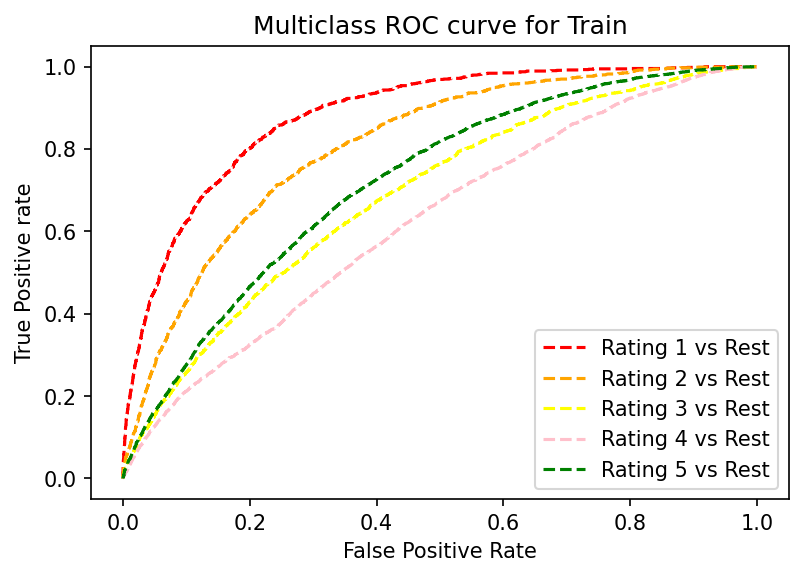

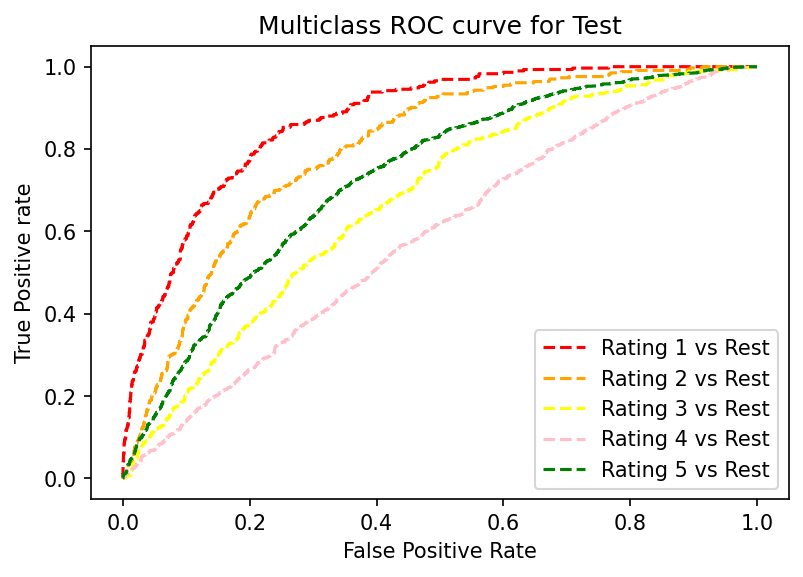

In [147]:
train_and_evaluate(df_with_scaled_counts)

#### Model Used - AutoGluon
* There is not much difference in the accuracy between the models using scaled counts and counts

# Question 3 [2 points]

1. Fit a multi-category machine learning model to the data using only the Review column as features and the Rating column as the label. 

2. Report the confusion matrix, accuracy, precision, recall, f1 score, Matthews correlation coefficient, ROC curve, and the AUC. 

(Think about how you would like to manage the text column. Do you want to remove numbers, punctuation, stopwords, and do stemming?)

What framework did you choose? (lots of choices: Fasttext, spaCy, AutoGluon, TensorFlow, PyTorch, GLMnet, sklearn, etc.)

In [148]:
df_with_reviews = df2.loc[ : ,('Review', 'Rating')]
df_with_reviews

,Review,Rating
1,nice hotel expensive parking got good deal sta...,4
2,ok nothing special charge diamond member hilto...,2
3,nice rooms not 4* experience hotel monaco seat...,3
4,"unique, great stay, wonderful time hotel monac...",5
5,"great stay great stay, went seahawk game aweso...",5
...,...,...
20487,"best kept secret 3rd time staying charm, not 5...",5
20488,great location price view hotel great quick pl...,4
20489,"ok just looks nice modern outside, desk staff ...",2
20490,hotel theft ruined vacation hotel opened sept ...,1


No path specified. Models will be saved in: "AutogluonModels/ag-20220509_050741/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220509_050741/"
AutoGluon Version:  0.1.0
Train Data Rows:    16392
Train Data Columns: 1
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	5 unique label values:  ['5', '4', '3', '2', '1']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 5
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9933.03 MB
	Train Data (Original)  Memory Usage: 12.73 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features

Train size = (16392, 2)  | Test size = (4099, 2)


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
			Fitting RenameFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['Review']
			CountVectorizer fit with vocabulary size = 8979
		Reducing Vectorizer vocab size from 8979 to 3287 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueF

Training Complete
Model Evaluation on Train data


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Predictive performance on given data: accuracy = 0.823389458272328


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arra

Accuracy: 0.823389458272328
MCC: 0.7432070192244556
Confusion Matrix: 
      1     2     3     4     5
1  1073    22     5     8    21
2    48  1179    48   102    83
3    17    57  1118   380   180
4     3    14    38  3306  1426
5     4     5     4   430  6821
Rating: 1
Precision: 0.9371179039301311, Recall: 0.9503985828166519, F1:0.9437115215479331
Rating: 2
Precision: 0.9232576350822239, Recall: 0.8075342465753425, F1:0.8615272195834854
Rating: 3
Precision: 0.921681780708986, Recall: 0.6381278538812786, F1:0.7541315345699832
Rating: 4
Precision: 0.7823000473260767, Recall: 0.6906204303321496, F1:0.7336070120936424
Rating: 5
Precision: 0.799554565701559, Recall: 0.9390143171806168, F1:0.8636910414688194
Area under curve (AUC) Rating 1:  0.9976930032259305
Area under curve (AUC) Rating 2:  0.9899473962327849
Area under curve (AUC) Rating 3:  0.9746898158544802
Area under curve (AUC) Rating 4:  0.9312400641295943
Area under curve (AUC) Rating 5:  0.9513370943521795
Model Evaluation on

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Predictive performance on given data: accuracy = 0.823389458272328


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arra

Accuracy: 0.6279580385459869
MCC: 0.44354675709573643
Confusion Matrix: 
     1    2    3    4     5
1  169   75    7   23    18
2   50  125   62   56    40
3    9   55  103  206    59
4    3   12   38  601   598
5    1    2    3  208  1576
Rating: 1
Precision: 0.728448275862069, Recall: 0.5787671232876712, F1:0.6450381679389313
Rating: 2
Precision: 0.4646840148698885, Recall: 0.37537537537537535, F1:0.4152823920265781
Rating: 3
Precision: 0.4835680751173709, Recall: 0.23842592592592593, F1:0.31937984496124033
Rating: 4
Precision: 0.5493601462522852, Recall: 0.48003194888178913, F1:0.5123614663256607
Rating: 5
Precision: 0.687909209951986, Recall: 0.8804469273743016, F1:0.7723597157559421
Area under curve (AUC) Rating 1:  0.9682659196649288
Area under curve (AUC) Rating 2:  0.9193853970805643
Area under curve (AUC) Rating 3:  0.8620081255239423
Area under curve (AUC) Rating 4:  0.7734928645252949
Area under curve (AUC) Rating 5:  0.8827640687037123


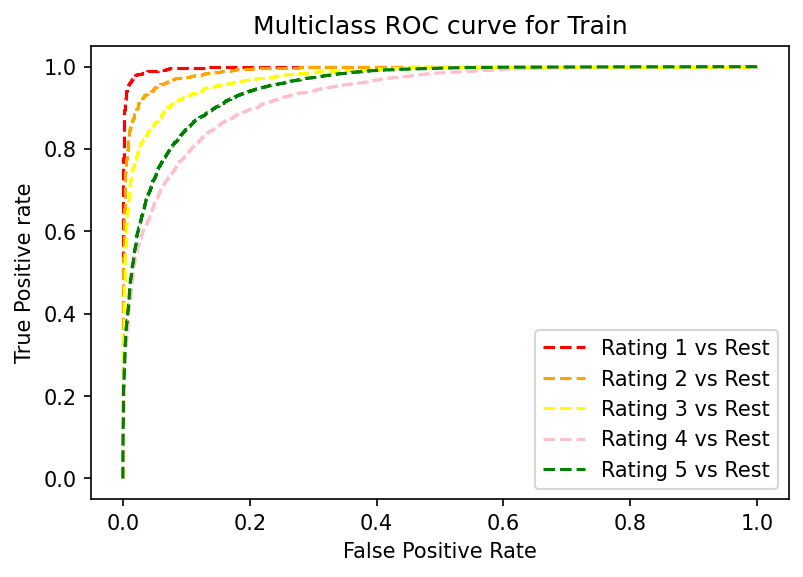

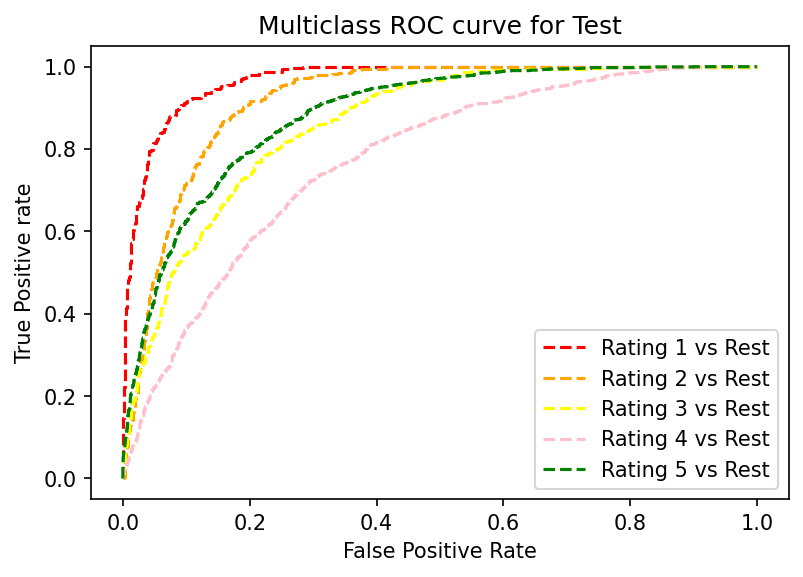

In [149]:
train_and_evaluate(df_with_reviews)

#### Model Used - AutoGluon

## Question 4 [3 points]

Now try and use the two new columns and the Review column to build a model that uses both, the text and the positive/negative scores to construct a model. 
``
Report the confusion matrix, accuracy, precision, recall, f1 score, Matthews correlation coefficient, ROC curve, and the AUC.

In [150]:
df_with_reviews_and_counts = df2.loc[ : ,('Review','Pos_Count','Neg_Count', 'Rating')]
df_with_reviews_and_counts

,Review,Pos_Count,Neg_Count,Rating
1,nice hotel expensive parking got good deal sta...,21,5,4
2,ok nothing special charge diamond member hilto...,41,20,2
3,nice rooms not 4* experience hotel monaco seat...,34,14,3
4,"unique, great stay, wonderful time hotel monac...",23,5,5
5,"great stay great stay, went seahawk game aweso...",36,21,5
...,...,...,...,...
20487,"best kept secret 3rd time staying charm, not 5...",17,15,5
20488,great location price view hotel great quick pl...,8,1,4
20489,"ok just looks nice modern outside, desk staff ...",10,8,2
20490,hotel theft ruined vacation hotel opened sept ...,130,114,1


No path specified. Models will be saved in: "AutogluonModels/ag-20220509_052311/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220509_052311/"
AutoGluon Version:  0.1.0
Train Data Rows:    16392
Train Data Columns: 3
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	5 unique label values:  ['5', '4', '3', '2', '1']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 5
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10535.35 MB
	Train Data (Original)  Memory Usage: 14.12 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the feature

Train size = (16392, 4)  | Test size = (4099, 4)


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting IdentityFeatureGenerator...
			Fitting RenameFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['Review']
			CountVectorizer fit with vocabulary size = 8979
		Reducing Vectorizer vocab size from 8979 to 3471 to avoid OOM error
	Sta

Training Complete
Model Evaluation on Train data


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Predictive performance on given data: accuracy = 0.9274036115178136


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Accuracy: 0.9274036115178136
MCC: 0.8951810365198345
Confusion Matrix: 
      1     2     3     4     5
1  1088    29     3     6     3
2    19  1358    30    34    19
3     6    19  1546   133    48
4     0     6    23  4159   599
5     2     1     3   207  7051
Rating: 1
Precision: 0.9757847533632287, Recall: 0.9636846767050488, F1:0.9696969696969698
Rating: 2
Precision: 0.9610757254069356, Recall: 0.9301369863013699, F1:0.945353289244692
Rating: 3
Precision: 0.9632398753894081, Recall: 0.882420091324201, F1:0.9210604706583259
Rating: 4
Precision: 0.9162811191892487, Recall: 0.8688113641111344, F1:0.891915076131246
Rating: 5
Precision: 0.9133419689119171, Recall: 0.9706773127753304, F1:0.941137213027229
Area under curve (AUC) Rating 1:  0.9987928221840774
Area under curve (AUC) Rating 2:  0.9967616207171139
Area under curve (AUC) Rating 3:  0.9906926822117423
Area under curve (AUC) Rating 4:  0.9817365842629763
Area under curve (AUC) Rating 5:  0.9868034153034474
Model Evaluation on 

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Predictive performance on given data: accuracy = 0.9274036115178136


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Accuracy: 0.6323493535008539
MCC: 0.4519802838952974
Confusion Matrix: 
     1    2    3    4     5
1  170   79   15   15    13
2   48  128   74   55    28
3    8   53  122  198    51
4    3   11   41  637   560
5    0    2    5  248  1535
Rating: 1
Precision: 0.74235807860262, Recall: 0.5821917808219178, F1:0.6525911708253358
Rating: 2
Precision: 0.46886446886446886, Recall: 0.3843843843843844, F1:0.42244224422442245
Rating: 3
Precision: 0.47470817120622566, Recall: 0.2824074074074074, F1:0.3541364296081277
Rating: 4
Precision: 0.5524718126626192, Recall: 0.5087859424920128, F1:0.5297297297297298
Rating: 5
Precision: 0.7018747142203933, Recall: 0.8575418994413407, F1:0.7719386472215237
Area under curve (AUC) Rating 1:  0.9686077557203565
Area under curve (AUC) Rating 2:  0.9210623262667873
Area under curve (AUC) Rating 3:  0.8558931511276753
Area under curve (AUC) Rating 4:  0.7702183005259726
Area under curve (AUC) Rating 5:  0.8832305455214113


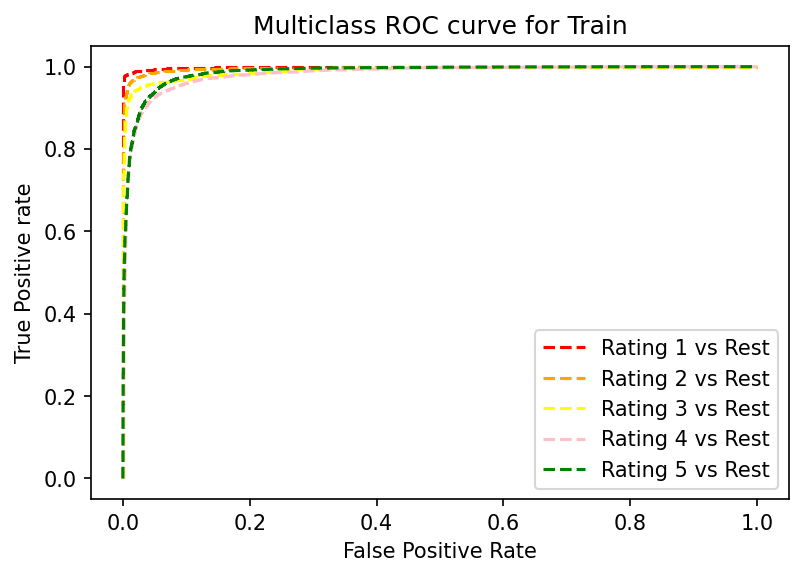

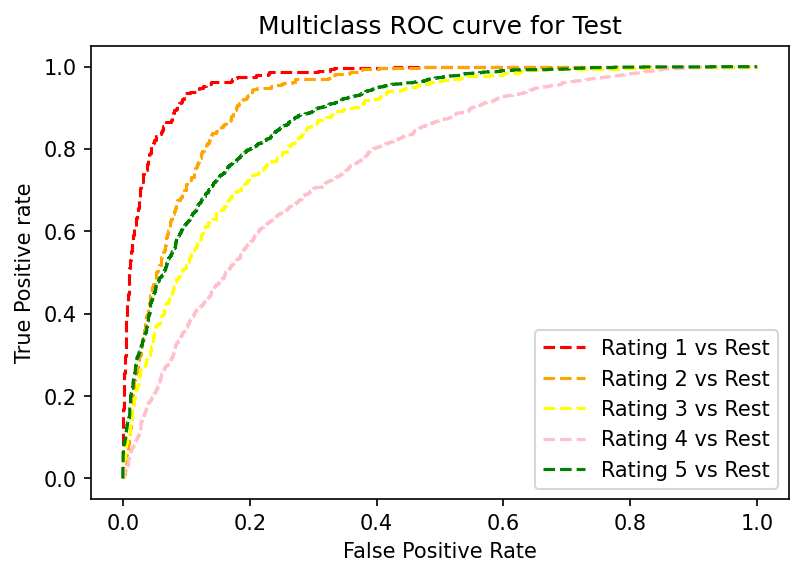

In [151]:
train_and_evaluate(df_with_reviews_and_counts)

#### Model Used - AutoGluon